In [21]:
#Parsing alignment for cluster Ia
from Bio import AlignIO
align = AlignIO.read("tmn_antitmn/20260130_recalculate_shennon_entropy/Tmn_mmseqs98_rep_seq_mod.withActiveWalker.muscle5.faa", "fasta")
RefRecID =""
RefSeq=""
#Reference is ECOR25 or WP_001683567.1
for record in align:
    if not record.id.startswith("WP_001683567.1"):
        next
    else:
        RefRecID=record.id
        RefSeq =str(record.seq)
        break
print(">"+RefRecID+"\n"+RefSeq)

>WP_001683567.1
------M----------------I-----M---------------S-----------T--------------------------P--------------------------------------------------------------------W-----------------------------------------------------------------------------------------------L----------T-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------P---I-----------V---------A-----------------------------D--S--------D----------H------------A------------------E--A--NA--VS-Y-EA-LTPT------E-------L--D-----------------S-D--K--A----GCYIS------ALNYAY---E------------------------H---PDIRNIAVTGPYGAGKSSVLKTWCK---------A-----------------------------------------------H---------------------------------------------------------------------------------------------------N--G-T-----------------------L------RVL-TVSLADFDMQR-H------V--D---------E--S--------------N------G--D-------------

In [22]:
#Recalculate Positions to reference
RefAliPosToSeq = dict()
letcount=0
for element in range(0, len(RefSeq)):
    if not RefSeq[element] == "-":
        RefAliPosToSeq[element] = letcount
        letcount+=1
    else:
        RefAliPosToSeq[element] = -1
dict(list(RefAliPosToSeq.items())[0:10])

{0: -1, 1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: 0, 7: -1, 8: -1, 9: -1}

In [23]:
#Define Shannon entropy
def shannon_entropy(list_input):
    import math
    unique_base = set(list_input)
    # I count here the depth of alignment
    M = len(list_input)
    entropy_list = []
    # Number of residues in column
    for base in unique_base:
        n_i = list_input.count(base)  # Number of residues of type i
        P_i = n_i/float(M)  # n_i(Number of residues of type i) / M(Number of residues in column)
        entropy_i = P_i*(math.log(P_i, 2))
        entropy_list.append(entropy_i)
        sh_entropy = -(sum(entropy_list))
        return sh_entropy
'''
Shannon's entropy equation (latex format):
H=-\\sum_{i=1}^{M} P_i\\,log_2\\,P_i
Entropy is a measure of the uncertainty of a probability distribution (p1, ..... , pM)
Where, Pi is the fraction of nuleotide bases of nuleotide base type i,
and M is the number of nuleotide base types (A, T, G or C)
H ranges from 0 (only one base/residue in present at that position) to 4.322 (all 20 residues are equally
represented in that position).
Typically, positions with H >2.0 are considerered variable, whereas those with H < 2 are consider conserved.
Highly conserved positions are those with H <1.0 (Litwin and Jores, 1992).
A minimum number of sequences is however required (~100) for H to describe the diversity of a protein family.
'''

"\nShannon's entropy equation (latex format):\nH=-\\sum_{i=1}^{M} P_i\\,log_2\\,P_i\nEntropy is a measure of the uncertainty of a probability distribution (p1, ..... , pM)\nWhere, Pi is the fraction of nuleotide bases of nuleotide base type i,\nand M is the number of nuleotide base types (A, T, G or C)\nH ranges from 0 (only one base/residue in present at that position) to 4.322 (all 20 residues are equally\nrepresented in that position).\nTypically, positions with H >2.0 are considerered variable, whereas those with H < 2 are consider conserved.\nHighly conserved positions are those with H <1.0 (Litwin and Jores, 1992).\nA minimum number of sequences is however required (~100) for H to describe the diversity of a protein family.\n"

In [24]:
#Calculate Entropy
gapcutoff = 0.200
ShEntropyDict = dict()
for col in range(align.get_alignment_length()):
    if RefAliPosToSeq[col] > 0:  # check if column is present in reference or not the first methionine
        AliColumn = align[:, col]
        countgaps = AliColumn.count('-')
        gapfraction = float(countgaps/len(AliColumn))
        if gapfraction < gapcutoff:
            aalistincol = list(set(AliColumn))
            if "-" in aalistincol:
                aalistincol.remove("-")
            ShEntropy = shannon_entropy(AliColumn)
            ShEntropyDict[RefAliPosToSeq[col]] = ShEntropy
# print(ShEntropyDict)

In [25]:
# Try to do conservation scores with PyCanal
# Check here: https://github.com/jafetgado/PyCanal/tree/master
from pycanal import Canal
canal = Canal(fastafile='tmn_antitmn/20260130_recalculate_shennon_entropy/Tmn_mmseqs98_rep_seq_mod.withActiveWalker.muscle5.faa', # Multiple sequence alignment (MSA) of homologous sequences
              ref=83, # Position of reference sequence in MSA, I use ECOR25 as before
              startcount=-16, # Position label of first residue in reference sequence
              verbose=True # Print out progress
              )
# Compute conservation scores for each site in reference sequence with relative entropy method
cons_scores = canal.analysis(include=None, method='relative')


785 sequences in fasta file

Multiple sequence alignment has 5613 total positions

Reference sequence is WP_192400439.1 YobI family P-loop NTPase [Pseudomonas sp. PDM15]

Reference sequence has 1266 residues (sites) and the first residue is labeled as position -16

Reference sequence residues are labeled as Y-1, G-2, L-3, I-4, A-5

Calculating amino acid frequencies...
Done.

Calculating conservation scores with relative method...
Done


In [26]:
import matplotlib.pylab as plt
import numpy as np
xvalues = np.arange(cons_scores.shape[0])
# Plot
"""
plt.figure(figsize=(30,6))
plt.scatter(xvalues,cons_scores, s=15, alpha=.5, c='#08519c')
plt.axvline(x = 37, color = '#cc4c02', label = 'axvline - full height')
plt.axvline(x = 61, color = '#8c6bb1', label = 'axvline - full height')
plt.axvline(x = 68, color = '#8c6bb1', label = 'axvline - full height')
plt.axvline(x = 271, color = '#8c6bb1', label = 'axvline - full height')
plt.axvline(x = 278, color = '#8c6bb1', label = 'axvline - full height')
plt.axvline(x = 358, color = '#cc4c02', label = 'axvline - full height')
plt.show()
"""

"\nplt.figure(figsize=(30,6))\nplt.scatter(xvalues,cons_scores, s=15, alpha=.5, c='#08519c')\nplt.axvline(x = 37, color = '#cc4c02', label = 'axvline - full height')\nplt.axvline(x = 61, color = '#8c6bb1', label = 'axvline - full height')\nplt.axvline(x = 68, color = '#8c6bb1', label = 'axvline - full height')\nplt.axvline(x = 271, color = '#8c6bb1', label = 'axvline - full height')\nplt.axvline(x = 278, color = '#8c6bb1', label = 'axvline - full height')\nplt.axvline(x = 358, color = '#cc4c02', label = 'axvline - full height')\nplt.show()\n"

In [28]:
# Extract the secondary structure from PDB

# Modified code from Patrick Kunzmann
# License: BSD 3 clause

#This creates the objects that can be plotted

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import biotite
import biotite.application.dssp as dssp
import biotite.database.entrez as entrez
import biotite.database.rcsb as rcsb
import biotite.sequence as seq
import biotite.sequence.graphics as graphics
import biotite.sequence.io.genbank as gb
import biotite.structure as struc
import biotite.structure.io.pdb as pdb

# Create 'FeaturePlotter' subclasses
# for drawing the scondary structure features


class HelixPlotter(graphics.FeaturePlotter):
    def __init__(self):
        pass

    # Check whether this class is applicable for drawing a feature
    def matches(self, feature):
        if feature.key == "SecStr":
            if "sec_str_type" in feature.qual:
                if feature.qual["sec_str_type"] == "helix":
                    return True
        return False

    # The drawing function itself
    def draw(self, axes, feature, bbox, loc, style_param):
        # Approx. 1 turn per 3.6 residues to resemble natural helix
        n_turns = np.ceil((loc.last - loc.first + 1) / 3.6)
        x_val = np.linspace(0, n_turns * 2 * np.pi, 100)
        # Curve ranges from 0.3 to 0.7
        y_val = (-0.4 * np.sin(x_val) + 1) / 2

        # Transform values for correct location in feature map
        x_val *= bbox.width / (n_turns * 2 * np.pi)
        x_val += bbox.x0
        y_val *= bbox.height
        y_val += bbox.y0

        # Draw white background to overlay the guiding line
        background = Rectangle(
            bbox.p0, bbox.width, bbox.height, color="white", linewidth=0
        )
        axes.add_patch(background)
        axes.plot(x_val, y_val, linewidth=2, color='#2b2d83') # '#dd3497')


class SheetPlotter(graphics.FeaturePlotter):
    def __init__(self, head_width=0.8, tail_width=0.5):
        self._head_width = head_width
        self._tail_width = tail_width

    def matches(self, feature):
        if feature.key == "SecStr":
            if "sec_str_type" in feature.qual:
                if feature.qual["sec_str_type"] == "sheet":
                    return True
        return False

    def draw(self, axes, feature, bbox, loc, style_param):
        x = bbox.x0
        y = bbox.y0 + bbox.height / 2
        dx = bbox.width
        dy = 0
        """
        if loc.defect & seq.Location.Defect.MISS_RIGHT:
            # If the feature extends into the prevoius or next line
            # do not draw an arrow head
            draw_head = False
        else:
            draw_head = True
        """
        axes.add_patch(
            biotite.AdaptiveFancyArrow(
                x,
                y,
                dx,
                dy,
                self._tail_width * bbox.height,
                self._head_width * bbox.height,
                # Create head with 90 degrees tip
                head_ratio=0.4,
                draw_head=False,
                color='#fec44f',
                linewidth=0,
            )
        )

# Test how the drawing functions work with example
annotation = seq.Annotation(
    [
        seq.Feature("SecStr", [seq.Location(10, 40)], {"sec_str_type": "helix"}),
        seq.Feature("SecStr", [seq.Location(60, 90)], {"sec_str_type": "sheet"}),
    ]
)
"""
fig = plt.figure(figsize=(8.0, 0.8))
ax = fig.add_subplot(111)
graphics.plot_feature_map(
    ax,
    annotation,
    multi_line=False,
    loc_range=(1, 100),
    # Register our drawing functions
    feature_plotters=[HelixPlotter(), SheetPlotter()],
)
fig.tight_layout()
"""

'\nfig = plt.figure(figsize=(8.0, 0.8))\nax = fig.add_subplot(111)\ngraphics.plot_feature_map(\n    ax,\n    annotation,\n    multi_line=False,\n    loc_range=(1, 100),\n    # Register our drawing functions\n    feature_plotters=[HelixPlotter(), SheetPlotter()],\n)\nfig.tight_layout()\n'

In [29]:
## Extract Secondary structure from Predicted AF2 model
# Converter for the DSSP secondary structure elements
# to the classical ones
dssp_to_abc = {
    "I": "c",
    "S": "c",
    "H": "a",
    "E": "b",
    "G": "c",
    "B": "b",
    "T": "c",
    "C": "c",
}

#Function to deal with DSSP input and vizualize it
def get_annotation(sse, first_id):
    """
    Helper function to convert secondary structure array to annotation.
    """

    def _add_sec_str(annotation, first, last, str_type):
        if str_type == "a":
            str_type = "helix"
        elif str_type == "b":
            str_type = "sheet"
        else:
            # coil
            return
        feature = seq.Feature(
            "SecStr", [seq.Location(first, last)], {"sec_str_type": str_type}
        )
        annotation.add_feature(feature)

    # Find the intervals for each secondary structure element
    # and add to annotation
    annotation = seq.Annotation()
    curr_sse = None
    curr_start = None
    for i in range(len(sse)):
        if curr_start is None:
            curr_start = i
            curr_sse = sse[i]
        else:
            if sse[i] != sse[i - 1]:
                _add_sec_str(
                    annotation, curr_start + first_id, i - 1 + first_id, curr_sse
                )
                curr_start = i
                curr_sse = sse[i]
    # Add last secondary structure element to annotation
    _add_sec_str(annotation, curr_start + first_id, i - 1 + first_id, curr_sse)
    return(annotation)

[+] Loading DSSP 2.3.0 on cn0005 


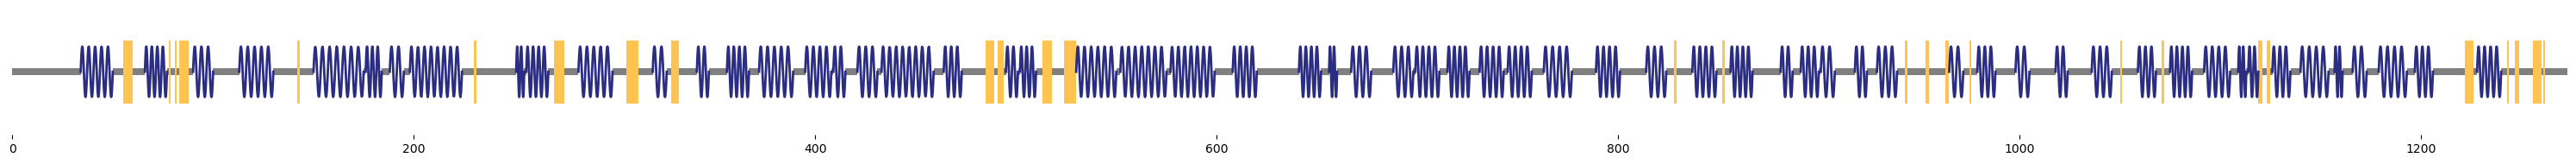

In [31]:
#This requires DSSP to run
# read more here: https://hpc.nih.gov/apps/DSSP.html
!module load DSSP

# Load the structure and plot the secondary structure
import os
import subprocess
PDB="tmn_antitmn/20250108_alignment_per_cluster/cluster_Ia/pdbs/WP_001683567.1.pdb"
pdb_file = pdb.PDBFile.read(PDB)
array = pdb.get_structure(pdb_file, model=1)

tmnECOR25 = array[struc.filter_amino_acids(array)]
#The trick here that without the complete path I get the Permission denied
sse = dssp.DsspApp.annotate_sse(tmnECOR25, bin_path="/usr/local/apps/DSSP/2.3.0/bin/mkdssp")
sse = np.array([dssp_to_abc[e] for e in sse], dtype="U1")
#get correctly formatted annotation
annotation = get_annotation(sse, tmnECOR25.res_id[0])

first_id = tmnECOR25.res_id[0]

fig = plt.figure(figsize=(30,2))
ax = fig.add_subplot(111)
graphics.plot_feature_map(
    ax,
    annotation,
    loc_range=(first_id, first_id + len(sse)),
    #show_numbers=True,
    show_line_position=True,
    symbols_per_line=len(sse),
    feature_plotters=[HelixPlotter(), SheetPlotter()],
)
fig.tight_layout()


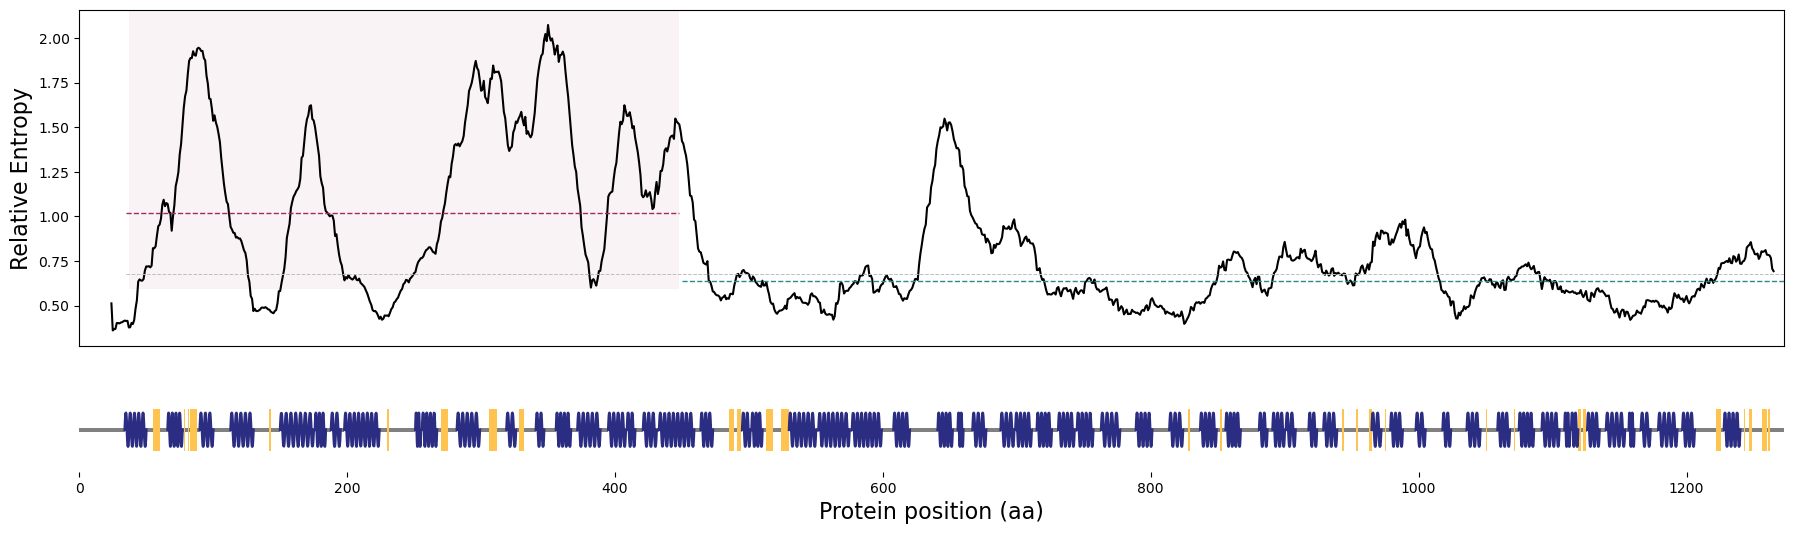

In [32]:
# Plot the outcomes

import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

cons_rolling = cons_scores.rolling(window=25).mean()
#print(np.mean(cons_rolling))
#print(np.nanmedian(cons_rolling))

fig=plt.figure(figsize=(22,6))

gs = gridspec.GridSpec(2, 1,height_ratios=[4,1])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
#Plotting the mean of relative entropy in a sliding window of size 25
ax1.plot(xvalues, cons_rolling, c='black',lw=1.5)
ax1.axhline(y=np.nanmedian(cons_rolling), xmin=35/1273, xmax=1,color='#bdbdbd', linestyle='--',lw=.7)
ax1.set_ylabel("Relative Entropy")
ax1.xaxis.set_visible(False)
#ax1.annotate('NTPase domain',xy=(120, 2.0),fontsize=10, color = '#cc4c02')
rect = patches.Rectangle((37,.6), 410, 1.8, linewidth=1, edgecolor='#cc4c02', facecolor='#a22762', alpha=.05, lw=.5)
ax1.add_patch(rect)
ax1.axhline(y=np.nanmedian(cons_rolling[0:409]), xmin=35/1273, xmax=448/1273,color='#a22762', linestyle='--',lw=1)
ax1.axhline(y=np.nanmedian(cons_rolling[410:1273]), xmin=450/1273, xmax=1,color='#268c90', linestyle='--',lw=1)
#plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=16)
#Adding info on the secondary structure from tmn25
ax2.sharex(ax1)
ax2.set_xlabel("Protein position (aa)")
graphics.plot_feature_map(
    ax2,
    annotation,
    loc_range=(first_id, first_id + len(sse)),
    #show_numbers=True,
    show_line_position=True,
    symbols_per_line=len(sse),
    feature_plotters=[HelixPlotter(), SheetPlotter()],
)

fig.savefig("tmn_antitmn/20260130_recalculate_shennon_entropy/Tmn_mmseqs98_rep_seq_mod.withActiveWalker_entropy_20260130.pdf")

In [33]:
# I can do Logo to vizualize the residues, but for the whole protein it m
# Read more here: https://www.tije.co/post/seqlogo_from_multiple_sequence_alignment/
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()

import logomaker as lm
raw_seqs=list()
#with open('cluster_Ia/tmn_clIa_muscle5_struct.fasta') as f:
with open('./tmn_antitmn/20260130_recalculate_shennon_entropy/Tmn_mmseqs98_rep_seq_mod.withActiveWalker.muscle5.faa') as f:
# I am updating the previous figure
    seq = ""
    for line in f:
        if line.startswith(">"):
            if seq != "":
                raw_seqs.append(seq+"\n")
            raw_seqs.append(line)
            seq=""
        else:
            seq=seq+line.rstrip("\n")
    raw_seqs.append(seq+"\n")
#raw_seqs[0:6]

In [34]:
seqs = [seq.strip() for seq in raw_seqs if ('#' not in seq) and ('>') not in seq]
# preview sequences
print('There are %d sequences, all of length %d'%(len(seqs), len(seqs[0])))
#seqs[:5]

There are 785 sequences, all of length 5613


In [48]:

# create counts matrix
ww_counts_df = lm.alignment_to_matrix(sequences=seqs, characters_to_ignore='.-X')
#Transform to information
ww_information_df=lm.transform_matrix(ww_counts_df,from_type='counts', to_type = 'information')
# transform to probabilities
#print(RefAliPosToSeq)
def GetCorrectIndex(s,e):
    RefPos = list()
    for j in list(ww_information_df.index[s:e+1]):
        #print(int(j))
        RefPos.append(RefAliPosToSeq[int(j)])

    walker = ww_information_df.loc[s:e]
    walker = walker.rename(index=dict(zip(list(walker.index),RefPos)))
    return(walker)

walkera = GetCorrectIndex(694,706)
walkerb = GetCorrectIndex(1568,1580)
#print(walkerb)

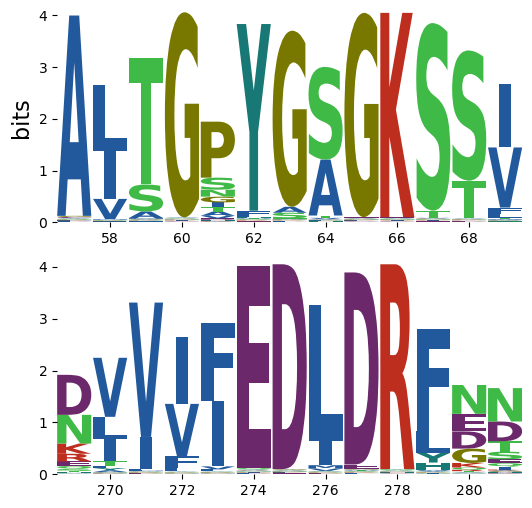

In [49]:
from matplotlib.ticker import MaxNLocator
# Draw Logo for Walker A and Walker B motifs
fig = plt.figure(figsize=(6,6))
#Walker A
ax1 = plt.subplot(211)
ax1.set_ylabel('bits')
lm.Logo(walkera, ax=ax1, figsize=(10,3), color_scheme='NajafabadiEtAl2017')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
#plt.xticks([])
for spine in plt.gca().spines.values():
    spine.set_visible(False)
#Walker B
ax2 = plt.subplot(212)
lm.Logo(walkerb,ax=ax2, figsize=(10,3), color_scheme='NajafabadiEtAl2017')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
#plt.xticks([])
for spine in plt.gca().spines.values():
    spine.set_visible(False)
#ax2.set_xticklabels([])

fig.savefig("tmn_antitmn/20260130_recalculate_shennon_entropy/tmn_785_WalkerA_Walker_B_logos.pdf")